In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
%matplotlib inline

## Image manipulation

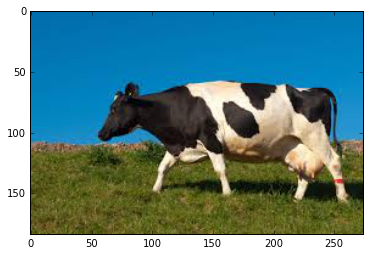

In [2]:
# read in an image and display it
img = cv2.imread("../images/cow3.jpg") 
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

### What is the type of img? hint: use the type() function

In [3]:
# put your code here


### You can select parts of an image using numpy slicing. 
Try to get a small image showing just the cow's front leg

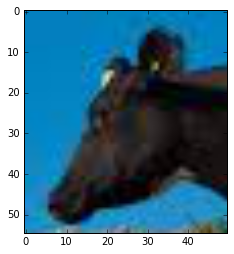

In [4]:
roi = rgb[55:110,50:100,:] #[ymin:ymax,xmin:xmax,channels]
plt.imshow(roi)

## Color spaces and tracking objects
The photos below contain the same set of object, photgraphed by different cameras and under different lighting conditions. Under each photo we plot the RGB and HSV histograms.

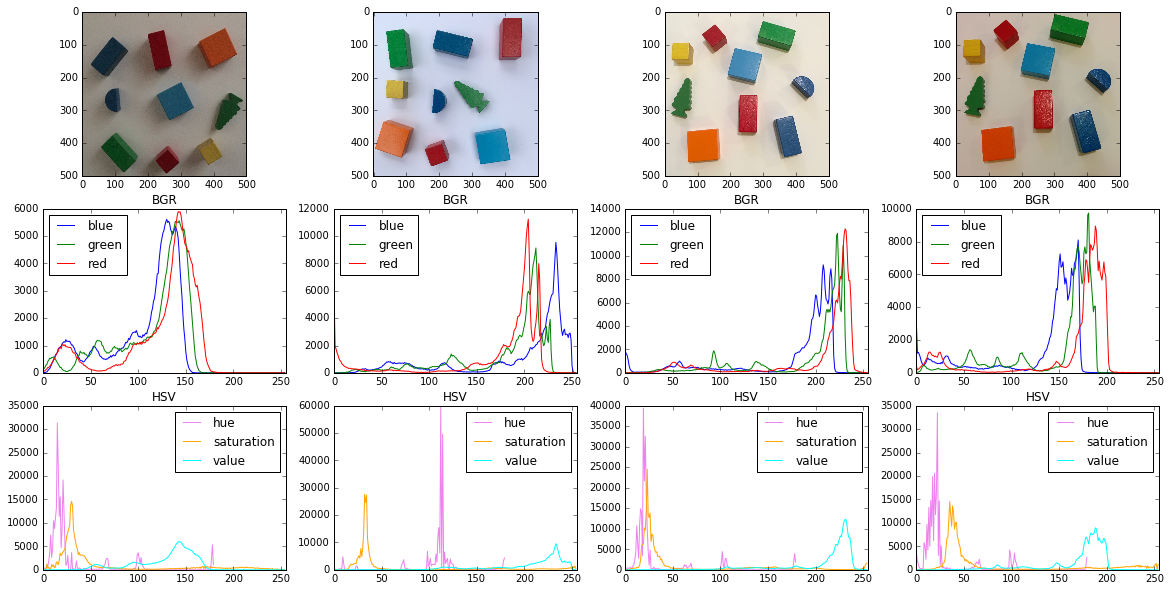

In [5]:
import os
images = [cv2.imread(os.path.join("../images/lighting",f)) for f in os.listdir("../images/lighting")]
hsv_images = [cv2.cvtColor(img,cv2.COLOR_BGR2HSV) for img in images]
rgb_images = [cv2.cvtColor(img,cv2.COLOR_BGR2RGB) for img in images]
fig,ax = plt.subplots(3,len(images),figsize=(20,10))
for indx,(img,hsv,rgb) in enumerate(zip(images,hsv_images,rgb_images)):
    ax[0,indx].imshow(rgb)
    plot_histogram(ax[1,indx],img,["blue","green","red"],"BGR")
    plot_histogram(ax[2,indx],hsv,["hue","saturation","value"],"HSV",legend_loc = "upper right")

It appears there is not much stability in the peaks of the histograms for either rgb or hsv accross the different lighting conditions. However, if you look carefully, you should see a large peak at low saturation in all the hsv histograms. These are the background pixels. Lets filter them out and then look at the histogram of hue for the remaining pixels. (Note: this works because we know all the objects we want to track have nice saturated colors - it is not a general solution)

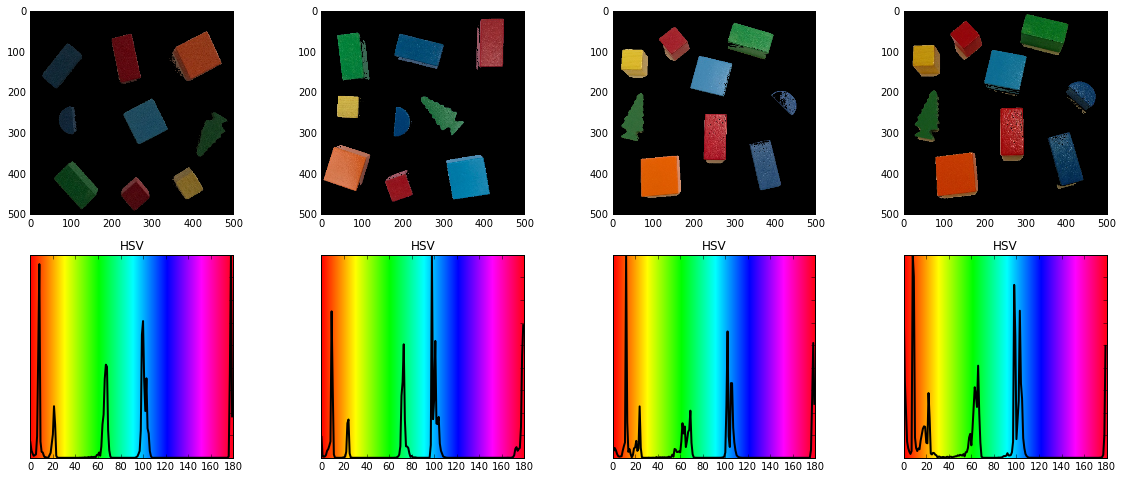

In [6]:
lower = np.array([0,100,5])
upper = np.array([180,256,256])
fig,ax = plt.subplots(2,len(images),figsize=(20,8))

for indx,(hsv,rgb) in enumerate(zip(hsv_images,rgb_images)):
    mask = cv2.inRange(hsv,lower,upper) # returns 255 if the pixel is in the specified range for all channels, 0 otherwise
    bmask = (mask > 0)
    pixels = hsv[:,:,0][mask > 0]
    res = cv2.bitwise_and(rgb,rgb, mask=mask)
    hsv_res = cv2.cvtColor(res,cv2.COLOR_RGB2HSV)
    ax[0,indx].imshow(res)
    plot_hsv_hist(ax[1,indx],pixels)



Try messing around with the range parameters to find each color of block as cleanly as possible

## Extracting colored objects

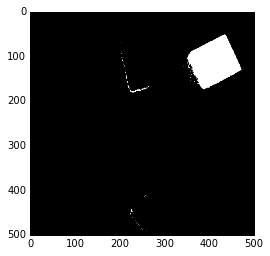

In [7]:
hsv = hsv_images[0]
lower = np.array([3,100,5])
upper = np.array([10,256,256])
img = hsvInRange(hsv,lower,upper)
plt.imshow(img,cmap="gray")

## Contours

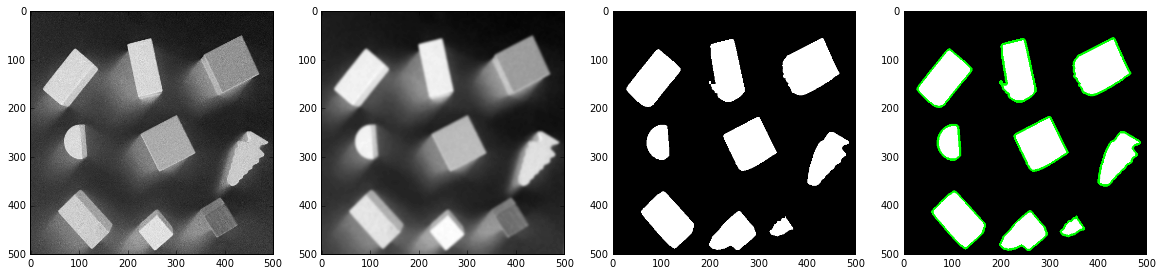

In [8]:
fig,ax = plt.subplots(1,4,figsize=(20,6))
im = cv2.bitwise_not(cv2.cvtColor(images[0],cv2.COLOR_BGR2GRAY))
im1 = cv2.GaussianBlur(im, (13, 13), 0)
ret,im2 = cv2.threshold(im1,170,255,cv2.THRESH_BINARY)

contour_im = im2
res,contours,hierarchy = cv2.findContours(contour_im.copy(), cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) #findContours modifies the image
rgb = cv2.cvtColor(contour_im,cv2.COLOR_GRAY2RGB)
cv2.drawContours(rgb, contours, -1, (0,255,0), 3)

ax[0].imshow(im,cmap="gray")
ax[1].imshow(im1,cmap="gray")
ax[2].imshow(im2,cmap="gray")
ax[3].imshow(rgb)

## Histogram back projection
* Obtain a representative sample of region of interest
* Create a histogram of the colors in that sample
* Normalize the histogram so that that the counts sum to 1. Now we interpret the bins in the histograms as the probability of seeing that color value in the region of interest.
* For all the pixels in an image, lookup the probability that that pixels color is in the roi.

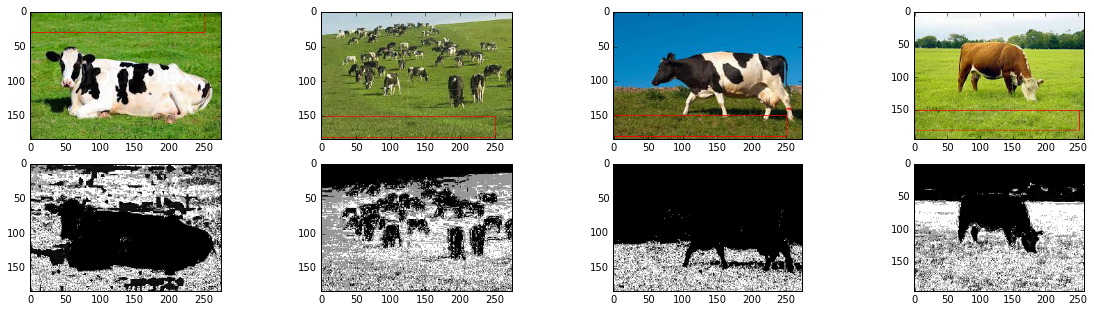

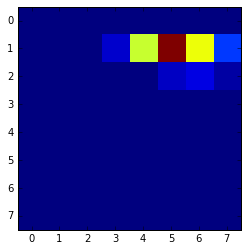

In [88]:
import os
path = "../images"
images = ["cow1.jpg","cow2.jpg","cow3.jpg","cow4.jpg"]
images = [cv2.imread(os.path.join(path,image),cv2.IMREAD_COLOR) for image in images]
rgb = [cv2.cvtColor(image,cv2.COLOR_BGR2RGB) for image in images]
hsv_images = [cv2.cvtColor(image,cv2.COLOR_BGR2HSV) for image in images]
rois = [(0,0,250,30),(0,150,250,180),(0,150,250,180),(0,150,250,180)]

# plot all the images with the regions we selected as containing grass (note they are all the same shape for convinient stacking)
fig,ax = plt.subplots(2,len(images),figsize = (20,5))

# make an hsv image containing all the grass regions we have selected.
grass = np.vstack((image[ymin:ymax,xmin:xmax] for ((xmin,ymin,xmax,ymax),image) in zip(rois,hsv_images) ))
hist = cv2.calcHist([grass],[0,1],mask = None, histSize = [8,8], ranges = [0, 180, 0, 256])
cv2.normalize(hist,hist,0,1,cv2.NORM_MINMAX)

for indx,image in enumerate(rgb):
    hsv = hsv_images[indx]
    xmin,ymin,xmax,ymax = rois[indx]
    cv2.rectangle(image,(xmin,ymin),(xmax,ymax),(255,0,0),1)
    ax[0,indx].imshow(image)
    dst = cv2.calcBackProject([hsv],[0,1],hist,[0, 180, 0, 256],scale=255) 
    ax[1,indx].imshow(dst,cmap="gray")
    
fig,ax = plt.subplots()
ax.imshow(hist,interpolation="nearest")

## Template matching


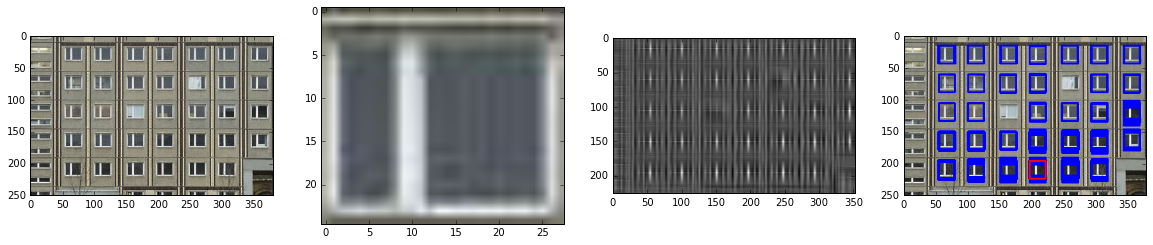

In [71]:
img = cv2.imread("../images/windows.jpg") #[ymin:ymax,xmin:xmax,channels]
rgb_orig = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
rgb = rgb_orig.copy()
template = rgb[16:41,54:82,:].copy()
w,h,_ = template.shape

method = cv2.TM_CCOEFF #'cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR', 'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED'
            
res = cv2.matchTemplate(rgb,template,method)
res = cv2.normalize(res, 0, 255, norm_type=cv2.NORM_MINMAX)

# draw a blue rectangle around all the places the template matches (above some threshold)
threshold = 180
matches = np.where(res > threshold)
for top_left in zip(matches[1],matches[0]):
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(rgb,top_left,bottom_right,(0,0,255),2)

# draw a red rectangle around the single best match for the template in the image    
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)   
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
cv2.rectangle(rgb,top_left, bottom_right, 255, 2)

fig,ax = plt.subplots(1,4,figsize=(20,5))
ax[0].imshow(rgb_orig)
ax[1].imshow(template)
ax[2].imshow(res,cmap="gray")
ax[3].imshow(rgb)


Play around with the different methods for template matching. If you look closely at the picture on the right, you will see many of the windows have been found multiple times. Can you think of a way to fix this?


## Feature matching

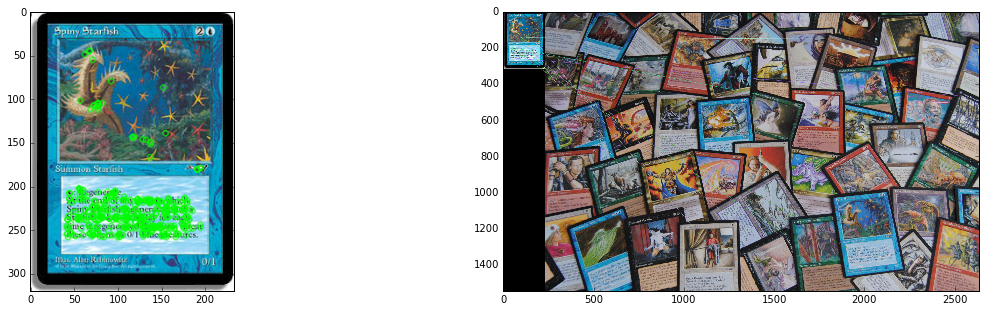

(<matplotlib.image.AxesImage at 0x7f10f8c50e50>, None)

In [110]:
img1 = cv2.cvtColor(cv2.imread("../images/spinystarfish_magic.jpg"),cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread("../images/magic_the_gathering.jpg"),cv2.COLOR_BGR2RGB)

orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1,None)
kp2,des2 = orb.detectAndCompute(img2,None)

img1_with_keypoints = cv2.drawKeypoints(img1, kp1, None, color=(0,255,0), flags=0)
fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].imshow(img1_with_keypoints), ax[1].imshow(img2)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=2)
plt.imshow(img3),plt.show()

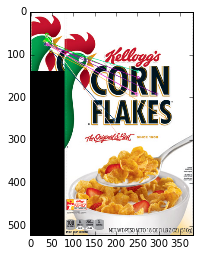

(<matplotlib.image.AxesImage at 0x7f10f9d30350>, None)

## OpenCV Gotya's
Numpy indexing is y first then x (number of rows,number of columns)
Opencv's drawing functions are x first then y (eg cv2.rectangle)

Don't expect the python bindings to behave in a pythonic way (keep an eye out for things getting clipped because they are uint8's, things failing silently without error is some condition (not usually documented in the python documentation is not met).


Experiment with the channel and binning to find find the grass. Try adding some smoothing and a threshold. 

## Blobs

In [ ]:
# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params() 
params.minThreshold = 80
params.maxThreshold = 100
params.thresholdStep = 5
params.minDistBetweenBlobs = 10
params.filterByArea,params.minArea = False,1500
params.filterByCircularity,params.minCircularity = False,0.1
params.filterByConvexity,params.minConvexity = False,0.87
params.filterByInertia,params.minInertiaRatio = False,0.01
detector = cv2.SimpleBlobDetector_create(params)

im = cv2.cvtColor(images[0],cv2.COLOR_BGR2GRAY)
im = cv2.GaussianBlur(im, (11, 11), 0)

thresholds = range(int(params.minThreshold),int(params.maxThreshold),int(params.thresholdStep))

fig,ax = plt.subplots(1,len(thresholds)+1,figsize=(20,5))
thresh_images = []
for indx,thresh in enumerate(thresholds):
    ret,thresh_img = cv2.threshold(im,thresh,255,cv2.THRESH_BINARY)
    thresh_images.append(thresh_img)
    ax[indx].imshow(thresh_img,cmap="gray")
    
keypoints = detector.detect(im)
im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(im_with_keypoints)

## Edges

In [ ]:
grey = cv2.cvtColor(rgb_images[0],cv2.COLOR_RGB2GRAY)[250:350,400:500]
@interact(minval = (0,255,5),maxval=(0,255,5))
def find_edges(minval,maxval):
    edges = cv2.Canny(grey,minval,maxval)
    fig,ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].imshow(grey,cmap = 'gray')
    ax[1].imshow(edges,cmap = 'gray')

## Resources
http://docs.opencv.org/3.2.0/d6/d00/tutorial_py_root.html

http://www.learnopencv.com/
